# Quickstart Guide to DSPS

This demo notebook begins by downloading the DSPS default option for the SSP spectral library. These data are stored [at this URL](https://portal.nersc.gov/project/hacc/aphearin/DSPS_data/) in a flat hdf5 file with column names as expected by the `dsps.load_ssp_templates` function, which we will demonstrate below.

When downloading and storing SSP libraries, you can optionally use the DSPS_DRN environment variable to specify the default location where DSPS will look for SSP libraries. But here we'll just save the downloaded data to `tempdata.h5`,  directly pass the filename to the data loader. The `load_ssp_templates` that we'll use to load these SSPs is just a convenience function - all of the DSPS functions that we'll demonstrate in this notebook accept plain arrays and floats as inputs, and so you can store your SSP data on disk in whatever format you like.

In [1]:
# ! curl https://portal.nersc.gov/project/hacc/aphearin/DSPS_data/ssp_data_fsps_v3.2_lgmet_age.h5 > tempdata.h5

### Inspect the SSP data

In [2]:
from dsps import load_ssp_templates
ssp_data = load_ssp_templates(fn='tempdata.h5')

print(ssp_data._fields)

print('\nssp_lgmet.shape = {}'.format(ssp_data.ssp_lgmet.shape))
print('ssp_lg_age.shape = {}'.format(ssp_data.ssp_lg_age.shape))
print('ssp_wave.shape = {}'.format(ssp_data.ssp_wave.shape))
print('ssp_flux.shape = {}'.format(ssp_data.ssp_flux.shape))

('ssp_lgmet', 'ssp_lg_age', 'ssp_wave', 'ssp_flux')

ssp_lgmet.shape = (12,)
ssp_lg_age.shape = (107,)
ssp_wave.shape = (5994,)
ssp_flux.shape = (12, 107, 5994)


The returned `ssp_data` is a namedtuple storing 4 ndarrays for the age-metallicity grid of the SSP spectra. Galaxy SEDs are calculated via probability-weighted sums of these spectral templates. For a galaxy observed at some $t_{\rm obs}$, we'll calculate the restframe SED of two different models in the cells below:

1. a galaxy with a tabulated star formation history (SFH), and metallicity Z distributed as a lognormal about some median Z, using the `calc_rest_sed_sfh_table_lognormal_mdf` function. 
2. a galaxy with SFH table and also tabulated history of metallicity (ZH), using the `calc_rest_sed_sfh_table_met_table` function.

In the cells below, we'll randomly generate an SFH and ZH for a galaxy, and plot the results.

In [3]:
import numpy as np

gal_t_table = np.linspace(0.05, 13.8, 100) # age of the universe in Gyr
gal_sfr_table = np.random.uniform(0, 10, gal_t_table.size) # SFR in Msun/yr

gal_lgmet = -2.0 # log10(Z)
gal_lgmet_scatter = 0.2 # lognormal scatter in the metallicity distribution function

t_obs = 8.0 # age of the universe in Gyr at z_obs

In [4]:
from dsps import calc_rest_sed_sfh_table_lognormal_mdf
from dsps import calc_rest_sed_sfh_table_met_table

sed_info = calc_rest_sed_sfh_table_lognormal_mdf(
    gal_t_table, gal_sfr_table, gal_lgmet, gal_lgmet_scatter,
    ssp_data.ssp_lgmet, ssp_data.ssp_lg_age, ssp_data.ssp_flux, t_obs)


gal_lgmet_table = np.linspace(-3, -2, gal_t_table.size)

sed_info2 = calc_rest_sed_sfh_table_met_table(
    gal_t_table, gal_sfr_table, gal_lgmet_table, gal_lgmet_scatter,
    ssp_data.ssp_lgmet, ssp_data.ssp_lg_age, ssp_data.ssp_flux, t_obs)

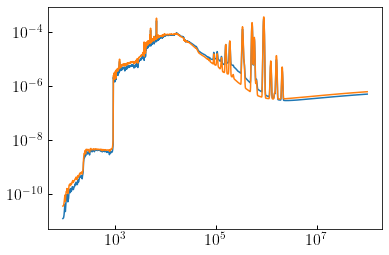

In [5]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 1)
__=ax.loglog()
__=ax.plot(ssp_data.ssp_wave, sed_info.rest_sed)
__=ax.plot(ssp_data.ssp_wave, sed_info2.rest_sed)

## Calculating photometry

Now we'll use dsps.photometry to calculate the apparent and absolute magnitudes of an SED observed through a broadband filter. One additional ingredient we need for this calculation is the transmission curve of some filter. For this, we'll download one from the same public URL where we previously downloaded the SSP spectra, and just write the result to a temporary file. But the `load_transmission_curve` function also supports the use of the DSPS_DRN environment variable in case you want DSPS to remember your default data location. The only difference is that you should store your transmission curves in the `filters` subdirectory of DSPS_DRN. And as above, you can also ignore this data-loading convenience function and store your transmission curves wherever you like and in whatever format you prefer.

In [6]:
# ! curl https://portal.nersc.gov/project/hacc/aphearin/DSPS_data/filters/lsst_g_transmission.h5 > tempfilter.h5

In [12]:
from dsps import load_transmission_curve
lsst_g = load_transmission_curve(fn="tempfilter.h5")

print(lsst_g._fields)

print('\nlsst_g.wave.shape = {}'.format(lsst_g.wave.shape))
print('lsst_g.transmission.shape = {}'.format(lsst_g.transmission.shape))


('wave', 'transmission')

lsst_g.wave.shape = (1806,)
lsst_g.transmission.shape = (1806,)


In [8]:
from dsps import calc_rest_mag
rest_mag = calc_rest_mag(ssp_data.ssp_wave, sed_info.rest_sed, lsst_g.wave, lsst_g.transmission)

In [9]:
# ! rm tempdata.h5

In [10]:
# ! rm tempfilter.h5